### Creating micrograd for back propagation and tracing a equation through its values


In [1]:
pip install numpy matplotlib # type: ignore

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [3]:
def f(x): #this is going to be an example of a function that takes in x and returns y as a result of a function
    return (4*x**2)- 3*x+5

In [4]:
f(3.0) 

32.0

In [5]:
a_few_x = np.arange(-5,5,0.25) #this will generate a few values for x using numpy and set the range from -5 to 5 with 0.25 step up
# a_few_x
a_few_y = f(a_few_x)
a_few_y

array([120. , 109.5,  99.5,  90. ,  81. ,  72.5,  64.5,  57. ,  50. ,
        43.5,  37.5,  32. ,  27. ,  22.5,  18.5,  15. ,  12. ,   9.5,
         7.5,   6. ,   5. ,   4.5,   4.5,   5. ,   6. ,   7.5,   9.5,
        12. ,  15. ,  18.5,  22.5,  27. ,  32. ,  37.5,  43.5,  50. ,
        57. ,  64.5,  72.5,  81. ])

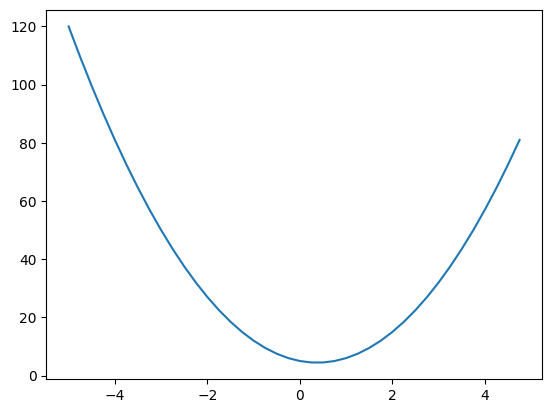

In [6]:
plt.plot(a_few_x,a_few_y) #plotting the graph of an quadratic eqn.

In [7]:
h = 0.000000000000001
x= 3
print(f(x+h))
(f(x+h) -f(x))/h #derivative calculation

32.000000000000014


14.210854715202002

In [8]:
a = 2.0
b = -3.0
c = 10.0
d= a*b+c
d  

4.0

In [9]:
h = 0.00001
a = 2.0
b = -3.0
c = 10.0
d1= a*b+c
c= c+h
d2 = a*b + c
print("d1",d1)
print("d2",d2)
print("slope",(d2-d1)/h)

d1 4.0
d2 4.00001
slope 0.9999999999621422


## Now we will write the value object for micrograd

In [76]:
class Value:
    def __init__(self,data,_children= (),_op='',label=''):
        self._backward = lambda:None
        self.data = data
        self.grad = 0.0 # 0 denotes change in the value doesn't affect the loss function
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __neg__(self):
        return self * -1
    def __sub__(self,other):
        return self + (-other)
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data,(self,other),'+')
            
        #_backward() takes out's grad and then we propagate it to self's grad and then the other's grad 
        def _backward():
            self.grad += 1.0 *out.grad
            other.grad += 1.0 *out.grad
                 
        out._backward = _backward
        return out
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad += other.data *out.grad
            other.grad += self.data *out.grad
                 
        out._backward = _backward
        return out
    def __truediv__(self,other):
        return self * other **-1
    def __pow__(self,other):
        assert isinstance(other,(int,float)),"only supports int or float for now"
        out = Value(self.data** other,(self,),f'**{other}')
        def _backward():
            self.grad += other * self.data ** (other-1) * out.grad
        out._backward = _backward
        return out
        
    def __rmul__(self,other):
        return self *other
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')
        
        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')
        
        def _backward():
            self.grad += out.data* out.grad
        out._backward = _backward
        return out
    def backward(self):
        ## FYI we recalled the draw_dot() ,method everytime in above _backward steps
        #its time to get rid of the manual calling by doing a topological sort

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [48]:
a = Value(2.0,label='a')
b = Value(4.0,label='b')
e = a*b
e.label = 'e'
c = Value(10.0,label='c')
d= e + c
d.label = 'd'
f = Value(-2.0,label='f')
L = d*f
L.label= 'L'
L
a*2 *2
a.exp()
a/b
a-b

Value(data=-2.0)

### visualizing the graph between values

In [12]:
pip install graphviz # type: ignore

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
from graphviz import Digraph

def trace(root):
    nodes,edge = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edge.add((child,v))
                build(child)
    build(root)
    return nodes,edge

def draw_dot(root):
    dot = Digraph(format="svg",graph_attr={'rankdir': 'LR'}) #this would mean left to right 
    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid,label="{%s | data %.4f |  grad %.4f }"  % (n.label,n.data,n.grad), shape='record') 
        if n._op:
            dot.node(name=uid+n._op,label=n._op)
            dot.edge(uid +n._op,uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) +n2._op)
    return dot   

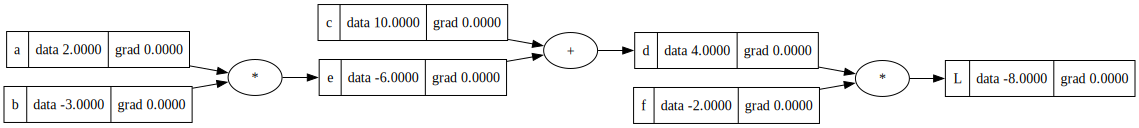

In [14]:
draw_dot(L)

now we need to do 
L = d*f
so we get 
dL/dd = f
how did we get this:
(f(x+h) - f(x))/h
now 
((d+h) *f - d*f)/h
(df +hf - df) / h
df cancells out
we get
hf/h
so f

so dl/df = d and dl/dd = f

In [15]:
f.grad = 4.0 #value of d
d.grad = -2.0 # value of f
L.grad = 1.0 # dl/dl = 1
c.grad = -2.0 #(explained below)
# now similarily e will also be
e.grad = -2.0
a.grad = -3.0 * -2.0
b.grad = 2.0 *-2.0 
# also we understand than any plus node will simply distribute 
# the nodes values to the leaf nodes and thus passing on the same values 
# so here we can say that since d is linked through the plus node with c and e 
# we get the value repeated there in there grad values

#### we are able to build out mathematical expression, using only scalar values and + and - signs and we can do a forward pass, and trace the expression that produces the output L
#### forward propagation, now we we do back propagation finding derivatives with respect to different values


now we need to find dl/dc for that we need to understand chain rule (see notebook),
but essentially it means 
dl/dc = dl/dd * dd/dc
we know dl/dd = -2.0
also dd/dc = 1.0
so dl/dc = -2.0 or f

now we need the final nodes, dl/de = -2 we know this
we want dl/da , so chain rule says
dl/de = dl/de *de/da
so if we solve this de/da we get d(ab)/da = b and then a for d(ab)/db 

In [16]:
def derive():
    a = Value(2.0,label='a')
    b = Value(-3.0,label='b')
    e = a*b
    e.label = 'e'
    c = Value(10.0,label='c')
    d= e + c
    d.label = 'd'
    f = Value(-2.0,label='f')
    L = d*f
    L.label= 'L'
    L1 = L.data
    # print(L1)
    h = 0.001
    a = Value(2.0,label='a')
    b = Value(-3.0,label='b')
    e = a*b
    c = Value(10.0,label='c')
    c.data+=h
    d= e + c
    d.label = 'd'
    e.label = 'e'
    f = Value(-2.0,label='f')
    L = d*f
    L.label= 'L'
    L2 = L.data
    print("result",(L2-L1)/h)

In [17]:
derive()

result -1.9999999999988916


In [53]:
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
b = Value(6.8813735870195432,label="b")
x1w1 = x1*w1 ; x1w1.label="x1w1"
x2w2 = x2*w2 ; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 +x2w2; x1w1x2w2.label="x1w1 + x2w2"
n = x1w1x2w2 +b; n.label='n'
# o = n.tanh()
# replacing it with the breakdown of the tanh Value
e = (2*n).exp()
o = (e-1)/(e+1) 
o.label = 'o'
o.backward()




In [19]:

## now we need to find derivative of o w.r.t to the rest of the things
# so we begin with do/do = 1, then we back propagate and we need do/dn
# we know do/dn = d(tanh)/dn = 1- tanh**2(h)
# then we have tan h = o
# 1- o**2
1- o.data **2


n.grad = 0.5
## now we also now plus is just a distributor of gradient,so it will just flow down
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
# now we have the first nodes since they are x1,w1,x2,w2, we have chain rule here
x2.grad = x2w2.grad* w2.data 
w2.grad = x2w2.grad* x2.data 
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data





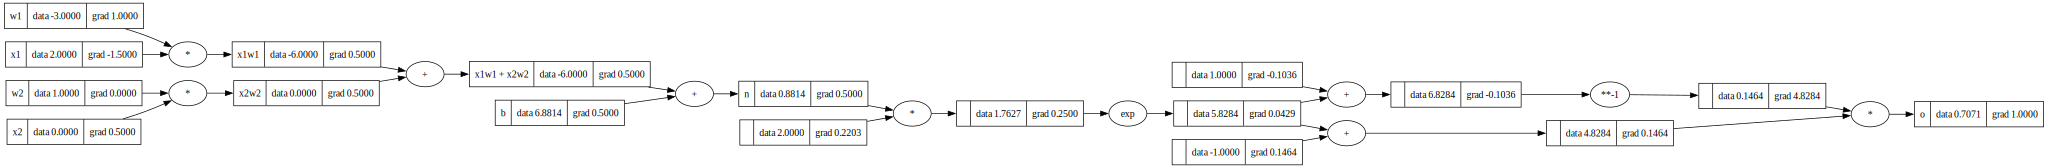

In [54]:
draw_dot(o)

In [30]:
# now we wrote the backward function so we are going to call it in the order it is supposed to be
o.grad = 1.0

o.backward()

In [31]:
o._backward()

In [32]:
n._backward()

In [33]:
b._backward()

In [34]:
x1w1x2w2._backward()

In [35]:
x1w1._backward()

In [27]:
x2w2._backward()

Now we will do the same thing in torch and hope to see the same results

In [58]:
%pip install torch
import torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [61]:
# x1 = Value(2.0,label="x1")
# x2 = Value(0.0,label="x2")
# w1 = Value(-3.0,label="w1")
# w2 = Value(1.0,label="w2")
# b = Value(6.8813735870195432,label="b")
# x1w1 = x1*w1 ; x1w1.label="x1w1"
# x2w2 = x2*w2 ; x2w2.label = "x2w2"
# x1w1x2w2 = x1w1 +x2w2; x1w1x2w2.label="x1w1 + x2w2"
# n = x1w1x2w2 +b; n.label='n'
# # o = n.tanh()
# # replacing it with the breakdown of the tanh Value
# e = (2*n).exp()
# o = (e-1)/(e+1) 
# o.label = 'o'
# o.backward()

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True
n = x1*w1 +x2*w2 +b
o = torch.tanh(n)
o.backward()
print(o.data.item())
print('x1',x1.grad.item())
print('x2',x2.grad.item())
print('w1',w1.grad.item())
print('w2',w2.grad.item())

0.7071066904050358
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


Implementing neural net with torch

In [89]:
import random
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # this is the wieght for each input
        self.b = Value(random.uniform(-1,1)) # this is the bias
    def __call__(self,x):
        activation = sum((wi*xi for wi,xi in zip(self.w,x)),self.b) #this decide how important the wieght was
        #and how active the neuron will be based onthe values given to it
        output= activation.tanh()
        return output
    def parameters(self):
        return self.w + [self.b]
        
class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) ==1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
class MLP(object):
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1] )for i in range(len(nouts))]
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]        


In [98]:
x=[2.0,3.0,-1] # we have 3 inputs
n = MLP(3,[4,4,1]) #3 layers with 2 layers of 4 and one output
print(len(n.parameters()))
# draw_dot(n(x))

41


In [101]:
# now lets run a simulation with some ground truth and values
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]

ys = [1.0,-1.0,-1.0,1.0] #desired targets



for k in range(20):        
    
    # forward pass
    ypred = [n(x) for x in xs]
    # calculating the net loss here:
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))
    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    for p in n.parameters():
        p.data += -0.05 *p.grad
    print(k,loss.data)
    #this is the backpropagation to fix the weights
    #so based on this value we can check this for each and every node and understand how its gradient affects the output if pos then positively else negative
    # we need to reset grad as well

0 0.02393223718481837
1 0.02268186315573097
2 0.02155342395616822
3 0.02053012609432267
4 0.019598097731537926
5 0.018745784020046525
6 0.01796348584619974
7 0.017243003980513504
8 0.016577361681404043
9 0.0159605863707629
10 0.01538753626650661
11 0.014853761571629855
12 0.014355392472206503
13 0.013889048114050765
14 0.01345176212871352
15 0.01304092131377777
16 0.012654214843406385
17 0.012289591965043537
18 0.011945226578153894
19 0.011619487427369943


In [102]:
ypred

[Value(data=0.9490980050993489),
 Value(data=-0.9568730528697812),
 Value(data=-0.9217709140761899),
 Value(data=0.9676155764408799)]